## 1. Setup

### 1.1 Import Dependencies

In [ ]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import pytorch dependencies - Functional API Style
import torch
import torch.nn as nn
import torch.nn.functional as F

### 1.2 Device Agnostic Code

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")

Using Device: cpu


### 1.3 Create Folder Structure

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

## 2. Collect Positive and Anchors

### 2.1 Download Labelled Faces in the Wild Dataset

In [9]:
import kagglehub

dataset_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

100%|██████████| 112M/112M [20:12<00:00, 97.2kB/s] 

Extracting files...


### 2.2 Move Images to the Negative File

In [ ]:
import shutil

# Path to the main LFW folder
lfw_path = r"C:\Users\TahaA\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4\lfw-deepfunneled\lfw-deepfunneled"

# Traverse each person's folder and copy images
for person_name in os.listdir(lfw_path):
    person_folder = os.path.join(lfw_path, person_name)

    if os.path.isdir(person_folder):
        for image_file in os.listdir(person_folder):
            if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                src = os.path.join(person_folder, image_file)
                dst_filename = f"{person_name}_{image_file}"  # avoid name collisions
                dst = os.path.join(NEG_PATH, dst_filename)
                shutil.copy2(src, dst)


### 2.3 Collect Positive and Anchor Classes

In [6]:
import uuid

In [7]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

while True:
    ret, frame = cap.read()

    if not ret:
        print("Failed to grab frame")
        break
    
    # Cut down frame to 250x250
    frame = frame[120:120+250, 200:200+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Show image back to screen
    cv2.imshow("Image Collection", frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()


## 3. Load & Preprocess Images

### 3.1 Create a Custom Dataset to Load a Limited Number of Images (300 from each folder)

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random

In [7]:
class ImageFolder(Dataset):
    def __init__(self, folder_path, transform=None, max_images=300):
        self.folder_path = folder_path
        self.image_files = [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        random.shuffle(self.image_files)
        self.image_files = self.image_files[:max_images]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

### 3.2 Define the Needed Tranforms

In [8]:
transform = transforms.Compose([
    transforms.Resize((105, 105)),
    transforms.ToTensor()
])

### 3.3 Create the Datasets

In [9]:
anchor_dataset = ImageFolder(r"E:\ROOT\FCAI\ML&DL_Courses\Projects\Deep_Facial_Recognition\data\anchor", transform=transform, max_images=300)
positive_dataset = ImageFolder(r"E:\ROOT\FCAI\ML&DL_Courses\Projects\Deep_Facial_Recognition\data\positive", transform=transform, max_images=300)
negative_dataset = ImageFolder(r"E:\ROOT\FCAI\ML&DL_Courses\Projects\Deep_Facial_Recognition\data\negative", transform=transform, max_images=300)

### 3.4 Create PairDataset (to combine anchor data with positive and negative data)

In [10]:
class PairDataset(Dataset):
    def __init__(self, anchor_dataset, other_dataset, label):
        self.anchor_dataset = anchor_dataset
        self.other_dataset = other_dataset
        self.label = label
        self.length = min(len(anchor_dataset), len(other_dataset))

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        anchor_img = self.anchor_dataset[idx]
        other_img = self.other_dataset[idx]
        label = torch.tensor(self.label, dtype=torch.float32)
        return anchor_img, other_img, label

In [11]:
positives = PairDataset(anchor_dataset, positive_dataset, label=1)
negatives = PairDataset(anchor_dataset, negative_dataset, label=0)

### 3.5 Concatenate Positives and Negatives

In [12]:
from torch.utils.data import ConcatDataset

data = ConcatDataset([positives, negatives])

### 3.6 Split the Data into Train and Test Sets

In [13]:
len(data), len(data) * 0.7, len(data) * 0.3

(600, 420.0, 180.0)

In [14]:
train_data, test_data = torch.utils.data.random_split(data, [420, 180])

### 3.7 Finally, Create the Dataloaders

In [15]:
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False)

## 4. Building a Siamese Neural Network

### 4.1 Build Embedding Layer

In [16]:
class EmbeddingModel(nn.Module):
    def __init__(self, input_shape: int):
        super().__init__()

        # First Block
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=64, kernel_size=10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Second Block
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Third Block
        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Fourth Block
        self.block_4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4),
            nn.ReLU()
        )

        # Classifier Block
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=9216, out_features=4096),
            nn.Sigmoid()
        )
    
    def forward(self, x: torch.Tensor):
        return self.classifier(self.block_4(self.block_3(self.block_2(self.block_1(x)))))

In [17]:
from torchinfo import summary

model = EmbeddingModel(input_shape=3)
summary(model, input_size=(1, 3, 105, 105))

Layer (type:depth-idx)                   Output Shape              Param #
EmbeddingModel                           [1, 4096]                 --
├─Sequential: 1-1                        [1, 64, 48, 48]           --
│    └─Conv2d: 2-1                       [1, 64, 96, 96]           19,264
│    └─ReLU: 2-2                         [1, 64, 96, 96]           --
│    └─MaxPool2d: 2-3                    [1, 64, 48, 48]           --
├─Sequential: 1-2                        [1, 128, 21, 21]          --
│    └─Conv2d: 2-4                       [1, 128, 42, 42]          401,536
│    └─ReLU: 2-5                         [1, 128, 42, 42]          --
│    └─MaxPool2d: 2-6                    [1, 128, 21, 21]          --
├─Sequential: 1-3                        [1, 128, 9, 9]            --
│    └─Conv2d: 2-7                       [1, 128, 18, 18]          262,272
│    └─ReLU: 2-8                         [1, 128, 18, 18]          --
│    └─MaxPool2d: 2-9                    [1, 128, 9, 9]            --
├

### 4.2 Build Distance Layer

In [18]:
# Siamese L1 Distance Class
class L1Dist(nn.Module):

    # Init method - Inheritence
    def __init__(self):
        super().__init__()

    # Similarity Calculation
    def forward(self, input_embedding, validation_embedding):
        return torch.abs(input_embedding - validation_embedding)

### 4.3 Make Siamese Model

In [19]:
class SiameseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = EmbeddingModel(input_shape=3)
        self.Dist = L1Dist()
        self.classifier = nn.Linear(in_features=4096, out_features=1)

    def forward(self, anchor_image, validation_image):
        return self.classifier(self.Dist(self.embedding(anchor_image), self.embedding(validation_image)))

In [20]:
Siamese_Model = SiameseModel()
summary(
    Siamese_Model,
    input_data=((torch.randn(1, 3, 105, 105), torch.randn(1, 3, 105, 105))),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    depth=4
)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
SiameseModel                             [1, 3, 105, 105]          [1, 1]                    --                        --
├─EmbeddingModel: 1-1                    [1, 3, 105, 105]          [1, 4096]                 --                        --
│    └─Sequential: 2-1                   [1, 3, 105, 105]          [1, 64, 48, 48]           --                        --
│    │    └─Conv2d: 3-1                  [1, 3, 105, 105]          [1, 64, 96, 96]           19,264                    [10, 10]
│    │    └─ReLU: 3-2                    [1, 64, 96, 96]           [1, 64, 96, 96]           --                        --
│    │    └─MaxPool2d: 3-3               [1, 64, 96, 96]           [1, 64, 48, 48]           --                        2
│    └─Sequential: 2-2                   [1, 64, 48, 48]           [1, 128, 21, 21]          --                        --
│    │   

## 5. Training

### 5.1 Setup loss and Optimizer

In [39]:
from torchmetrics.classification import BinaryConfusionMatrix, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryAccuracy

# Loss Function
loss_fn = nn.BCEWithLogitsLoss()
# Accuracy Function
acc_fn = BinaryAccuracy()
# Precision
prec_fn = BinaryPrecision()
# recall
recall_fn = BinaryRecall()
# F1-score
f1_score = BinaryF1Score()

# Optimizer
optimzer = torch.optim.Adam(params=Siamese_Model.parameters(), lr=0.0001)

### 5.2 Establish Checkpoints

In [32]:
# Paths
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

### 5.3 Build the Train Step Function

In [35]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               acc_fn,
               device: torch.device = device):
    # Put the model and acc_fn on the target device
    model.to(device)
    acc_fn.to(device)
    
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader
    for batch, (anc_img, val_img, label) in enumerate(dataloader):
        # Send data to target device
        anc_img, val_img, label = anc_img.to(device), val_img.to(device), label.to(device)

        # 1. Forward pass
        y_pred = model(anc_img, val_img).squeeze(dim=1)

        # Convert logits -> pred probs
        # y_pred_probs = torch.sigmoid(y_pred)

        # Convert probs -> labels
        y_pred_labels = torch.round(torch.sigmoid(y_pred))

        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, label)
        train_loss += loss.item()

        # Calculate the accuracy metric
        acc = acc_fn(y_pred_labels, label)
        train_acc += acc.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [36]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              acc_fn,
              prec_fn = BinaryPrecision(),
              recall_fn = BinaryRecall(),
              f1_score_fn = BinaryF1Score(),
              device: torch.device = device):
    # Send model and evaluation metrics to the target device
    model.to(device)
    acc_fn.to(device)
    prec_fn.to(device)
    recall_fn.to(device)
    f1_score_fn.to(device)

    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Setup evaluation metrics
    test_prec, test_recall, test_f1_score = 0, 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (anc_img, val_img, label) in enumerate(dataloader):
            # Send data to target device
            anc_img, val_img, label = anc_img.to(device), val_img.to(device), label.to(device)

            # 1. Forward pass
            test_pred = model(anc_img, val_img).squeeze(dim=1)

            # Convert logits -> probs
            test_pred_probs = torch.sigmoid(test_pred)

            # Convert probs -> labels
            test_pred_labels = torch.round(test_pred_probs)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred, label)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_acc += acc_fn(test_pred_labels, label).item()

            # Calculate evaluation metric
            precision = prec_fn(test_pred_labels, label)
            test_prec += precision.item()

            recall = recall_fn(test_pred_labels, label)
            test_recall += recall.item()

            f1_score = f1_score_fn(test_pred_labels, label)
            test_f1_score += f1_score.item()

        # Adjust metrics to get average value per batch
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)
        test_prec = test_prec / len(dataloader)
        test_recall = test_recall / len(dataloader)
        test_f1_score = test_f1_score / len(dataloader)

    return test_loss, test_acc, test_prec, test_recall, test_f1_score

In [42]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          acc_fn,
          epochs: int = 5,
          device: torch.device = device,
          save_path: str = checkpoint_prefix):
    # 2. Create empty results dictionary
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'test_prec': [],
        'test_recall': [],
        'test_f1_score': []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           acc_fn=acc_fn)
        test_loss, test_acc, test_prec, test_recall, test_f1_score = test_step(model=model,
                                                                               dataloader=test_dataloader,
                                                                               loss_fn=loss_fn,
                                                                               acc_fn=acc_fn,
                                                                               device=device)
        
        # 4. Print out what's happening
        print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {100*train_acc:.2f}%")

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_prec"].append(test_prec)
        results["test_recall"].append(test_recall)
        results["test_f1_score"].append(test_f1_score)

        # 6. Save model checkpoint dynamically
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc
        }

        if epoch % 2 == 0:
            torch.save(checkpoint, f"{save_path}_epoch_{epoch + 1}.pth")
            print(f"Checkpoint saved for epoch {epoch + 1}\n")

    return results

In [43]:
# Set random seeds
torch.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = train(model=Siamese_Model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimzer,
                      loss_fn=loss_fn,
                      acc_fn=acc_fn,
                      epochs=NUM_EPOCHS,
                      device=device,
                      save_path=checkpoint_prefix)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 0.1145 | Train acc: 97.22%
Checkpoint saved for epoch 1

Epoch: 2 | Train loss: 0.0798 | Train acc: 97.45%
Epoch: 3 | Train loss: 0.0654 | Train acc: 98.38%
Checkpoint saved for epoch 3

Epoch: 4 | Train loss: 0.0467 | Train acc: 99.31%
Epoch: 5 | Train loss: 0.0318 | Train acc: 99.31%
Checkpoint saved for epoch 5

Epoch: 6 | Train loss: 0.0311 | Train acc: 99.77%
Epoch: 7 | Train loss: 0.0067 | Train acc: 100.00%
Checkpoint saved for epoch 7

Epoch: 8 | Train loss: 0.0095 | Train acc: 100.00%
Epoch: 9 | Train loss: 0.0039 | Train acc: 100.00%
Checkpoint saved for epoch 9

Epoch: 10 | Train loss: 0.0017 | Train acc: 100.00%
Total training time: 401.609 seconds


## 6. Evaluate the Model

### 6.1 Sample Random Image

In [44]:
test_samples = []
test_labels = []

for in_sample, val_sample, label in random.sample(list(test_data), k=9):
    test_samples.append((in_sample, val_sample))
    test_labels.append(label)

test_samples[0][0].shape

torch.Size([3, 105, 105])

### 6.2 Make Prediction Function

In [47]:
def make_predictions(model: nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.to(device)

    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample
            in_sample = torch.unsqueeze(sample[0], dim=0).to(device)
            val_sample = torch.unsqueeze(sample[1], dim=0).to(device)

            # Forward pass
            pred_logits = model(in_sample, val_sample)

            # Get prediction probabilities
            pred_prob = torch.sigmoid(pred_logits.squeeze())

            # Get pred_prob off the GPU
            pred_probs.append(pred_prob.cpu())
    
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [48]:
# Make predictions
pred_probs = make_predictions(model=Siamese_Model,
                              data=test_samples,
                              device=device)

# View the first two prediction probabilities
pred_probs[:2]

tensor([1.0000, 0.9992])

In [ ]:
# Convert prediction probabilities to labels
pred_classes = torch.round(pred_probs).type(torch.int)
pred_classes

tensor([1, 1, 1, 0, 1, 1, 0, 1, 1], dtype=torch.int32)

### 6.3 Plot Predictions

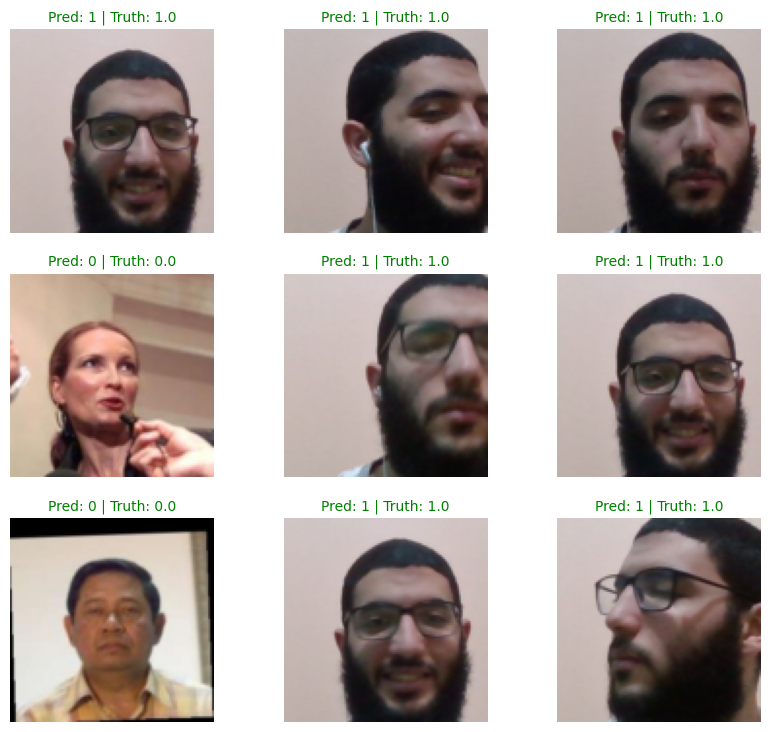

In [ ]:
# Plot predictions
plt.figure(figsize=(10, 9))
nrows, ncols = 3, 3
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the image
    plt.imshow(sample[1].permute(1, 2, 0))

    # Find the prediction label
    pred_label = pred_classes[i]

    # Find the truth label
    truth_label = test_labels[i]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')

    plt.axis(False)

### 6.4 Plot the loss & accuracy Curves

In [55]:
def plot_loss_curves(results: dict[str, list[float]]):
    # Get the loss values of the results dictionary
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

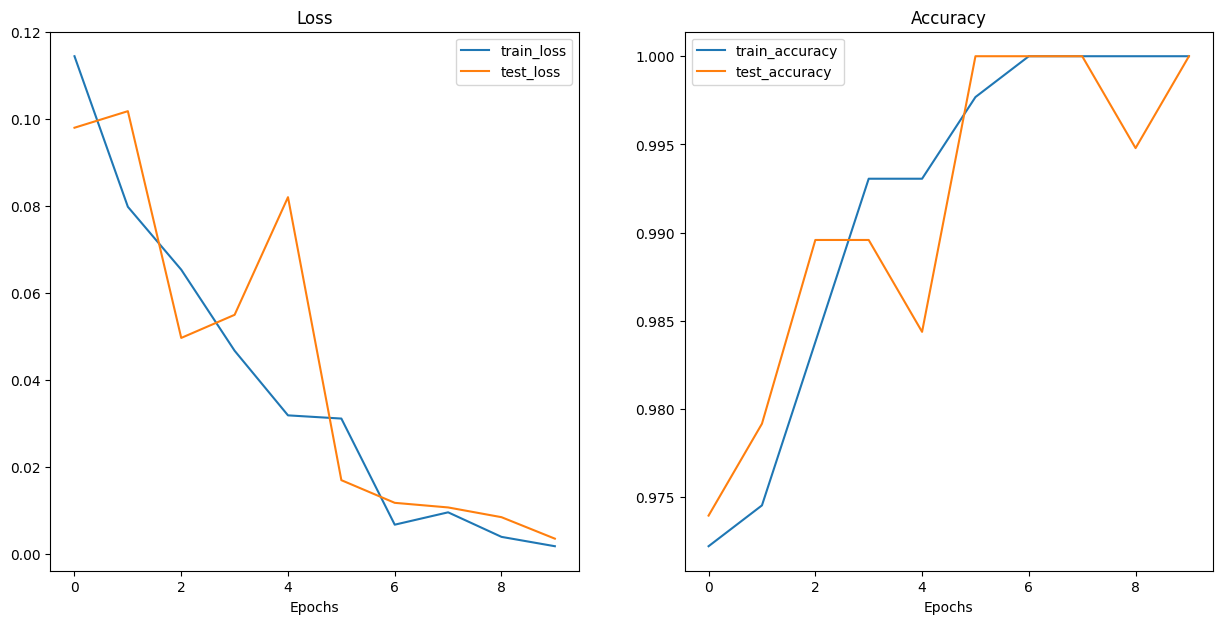

In [56]:
plot_loss_curves(results=model_results)

In [57]:
# Plotting Evaluation metrics through epochs
def plot_evaluation_metrics(results_dict, title="Evaluation Metrics Over Epochs"):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 7))
    # Plot accuracy through epochs
    metric = BinaryAccuracy()
    values = torch.Tensor(results_dict["test_acc"])
    fig_, ax_ = metric.plot(values, ax1)
    
    # Plot precision through epochs
    metric = BinaryPrecision()
    values = torch.Tensor(results_dict["test_prec"])
    fig_, ax_ = metric.plot(values, ax2)

    # Plot recall through epochs
    metric = BinaryRecall()
    values = torch.Tensor(results_dict["test_recall"])
    fig_, ax_ = metric.plot(values, ax3)

    # Plot recall through epochs
    metric = BinaryF1Score()
    values = torch.Tensor(results_dict["test_f1_score"])
    fig_, ax_ = metric.plot(values, ax4)

    # Add a title to the entire figure
    fig.suptitle(title, fontsize=20)

    # Adjust spacing to fit the title and plots
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
    
    plt.show()


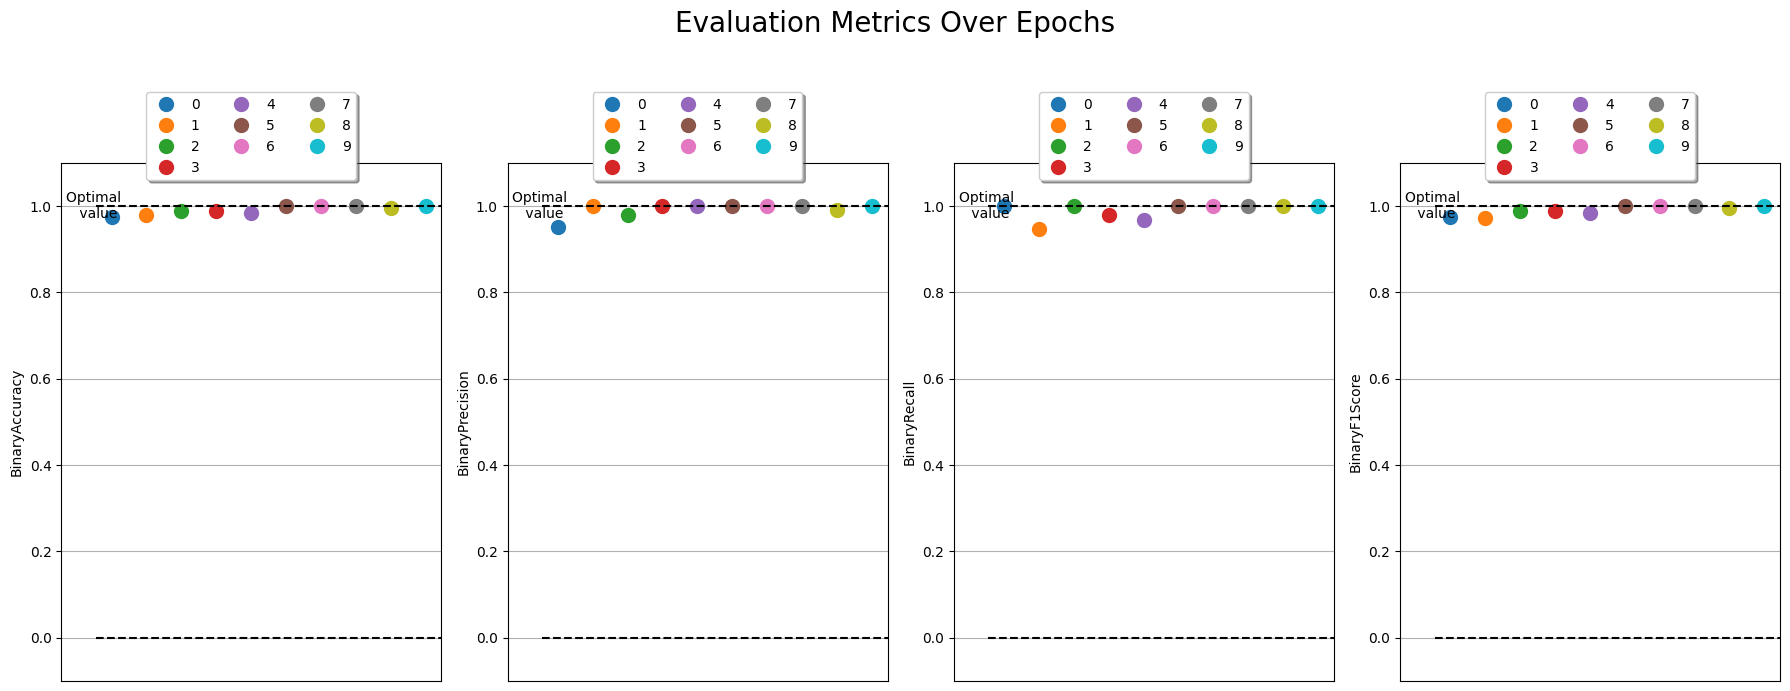

In [58]:
plot_evaluation_metrics(model_results)

## 7. Save the Model

In [59]:
from pathlib import Path

# Create models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save path
MODEL_NAME = "Siamese_Model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=Siamese_Model.state_dict(), # only saving the state_dict() only saves the learned params
           f=MODEL_SAVE_PATH)

Saving model to: models\Siamese_Model.pth


In [62]:
torch.manual_seed = 42

# Create a new instance of our model
loaded_siamese_model = SiameseModel()

# Load in the saved state_dict()
loaded_siamese_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to the target device
loaded_siamese_model = loaded_siamese_model.to(device)
loaded_siamese_model

C:\Users\TahaA\AppData\Local\Temp\ipykernel_70652\3552534811.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_siamese_model.load_state_dict(torch.load(f=MODEL_SAVE

SiameseModel(
  (embedding): EmbeddingModel(
    (block_1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block_2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block_3): Sequential(
      (0): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block_4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
      (1): ReLU()
    )
    (classifier): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=9216, out_features=4096, bias=True)
      (2): Sigmoid()
    )
  )
  (Dist): L1Dist()
  (classifier): Linear(in_features=4096, out_features

## 8. Real Time Test

### 8.1 Setup paths and Folders

In [64]:
import shutil
torch.random.manual_seed(42)

# Setup paths for input image and verification images
INPUT_IMAGE_PATH = os.path.join('application_data', 'input_image')
VERIFICATION_IMAGES_PATH = os.path.join('application_data', 'verification_images')

# Make directories if they don't exist
if not os.path.exists(INPUT_IMAGE_PATH):
    os.makedirs(INPUT_IMAGE_PATH)
if not os.path.exists(VERIFICATION_IMAGES_PATH):
    os.makedirs(VERIFICATION_IMAGES_PATH)

positive_images_path_list = [os.path.join(POS_PATH, f) for f in os.listdir(POS_PATH) if f.endswith(".jpg")]

# Randomly select on 50 image from the positive images path list
positive_images_path_list = random.sample(positive_images_path_list, k=50)

# Copy the images to the verification images path
for image_path in positive_images_path_list:
    shutil.copy(image_path, VERIFICATION_IMAGES_PATH)
print(f"images copied to {VERIFICATION_IMAGES_PATH}")


images copied to application_data\verification_images


### 8.2 Verification Function

In [65]:
def process(image_path):
    img = Image.open(image_path).convert("RGB")
    transformed_image = transform(img)
    return transformed_image.to(device)

In [72]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []

    # Loop through the verification images
    for image_path in os.listdir(VERIFICATION_IMAGES_PATH):

        # Read the verification image and input image and process them (resize, normalize and convert to tensor)
        verification_image_path = os.path.join(VERIFICATION_IMAGES_PATH, image_path)
        input_image_path = os.path.join(INPUT_IMAGE_PATH, 'input_image.jpg')
        verification_image = process(verification_image_path)
        input_image = process(input_image_path)

        # Make predictions
        data = [(verification_image, input_image)]
        pred_probs = make_predictions(model=model,
                                      data=data,
                                      device=device)
        results.append(pred_probs.item())

    # Calculate the detection results and verification results
    detection_results = sum(np.array(results) > detection_threshold)
    verification_results = detection_results / len(results)
    verified = verification_results > verification_threshold

    return results, verified

### 8.3 OpenCV Real Time Verification

In [76]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join(INPUT_IMAGE_PATH, 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(loaded_siamese_model, 0.9, 0.7)
        if (verified):
            print("Verified, wala3 eldonia🔥")
        if (~verified):
            print("Not Verified!🥸")
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Verified, wala3 eldonia🔥
Verified, wala3 eldonia🔥
Verified, wala3 eldonia🔥
Verified, wala3 eldonia🔥
Not Verified!🥸
